In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from sklearn.decomposition import PCA
from scipy.sparse import csgraph
import umap
from collections import Counter
import sklearn
from importlib import reload

import gget

# locals
import utils as ut
reload(ut)

2023-02-22 14:28:55.868531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 14:28:55.979556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2023-02-22 14:28:55.979584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 14:28:56.005476: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-22 14:28:56.8312

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath)
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
lr.head()

(2000, 8)


Pair.Name Ligand.Mouse Receptor.Mouse      Source ManualAnnotation  \
0          A2m-Lrp1          A2m           Lrp1  Ramilowski          Correct   
1       Adgre5-Cd55       Adgre5           Cd55      Baccin          Correct   
2    Adipoq-Adipor1       Adipoq        Adipor1  Ramilowski          Correct   
3    Adipoq-Adipor2       Adipoq        Adipor2  Ramilowski          Correct   
4  Adm-Calcrl&Ramp2          Adm   Calcrl&Ramp2      Baccin          Correct   

  Ligand.CC Ligand.GO     Reference (PMID / KEGG)  ligand      receptor  
0  Secreted     Other  1702392,10652313, 12194978     A2M          LRP1  
1  Membrane     Other                    23447688  ADGRE5          CD55  
2  Secreted     Other                    12802337  ADIPOQ       ADIPOR1  
3  Secreted     Other          12802337, 12802330  ADIPOQ       ADIPOR2  
4  Secreted     Other                    10342881     ADM  CALCRL&RAMP2

In [3]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...
HFD14...
done


In [4]:
sptDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"

spt = {}

for f in os.listdir(sptDir):
    if "spt" in f and "macrophage" in f:
        print(f)
        fullPath = f"{sptDir}{f}"
        key = f.split("_")[0]
        sdf = pd.read_csv(fullPath)
        sdf = sdf.rename(columns={'Unnamed: 0' : 'gene'})
        sdf = sdf.set_index('gene')
        sdf = sdf.T
        sdf.index = sdf.index.str.replace("-", ".")
        sdf = ut.normalize(sdf, 1e6)
        spt[key] = sdf
    
print('done')

HFD8_macrophage_spt.csv
HFD14_macrophage_spt.csv
ND_macrophage_spt.csv
done


In [5]:
t = 0.05 # ten percent of the cells
res = []

# prepare the data
keys = ['ND', 'HFD8', 'HFD14']
cData = {}

for key in keys:
    rf = rna[key]
    
    rbin = rf.astype(bool).astype(int)
    colSums = rbin.sum(axis=0)
    colSums = colSums / len(rbin)
    colInd = np.where(colSums > t)[0]
    rf = rf[rf.columns[colInd]]
    print(key, rf.shape)
    cData[key] = rf

ND (1261, 8877)
HFD8 (6123, 8246)
HFD14 (6436, 8001)


In [6]:
res = []

comps = [
    ('ND', 'HFD8'),
    # ('ND', 'HFD14'),
    ('HFD8', 'HFD14'),
]

for ikey, jkey in comps:        
    irf = cData[ikey]
    jrf = cData[jkey]

    for gene in irf.columns:
        if gene in irf.columns and gene in jrf.columns:
            score, pval = scipy.stats.ranksums(irf[gene], 
                                               jrf[gene],
                                               alternative='two-sided')

            lfc = np.log2(jrf[gene].mean()) - np.log2(irf[gene].mean())

            row = {
                'ikey' : ikey,
                'jkey' : jkey,
                'gene' : gene,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc,
                'meani' : irf[gene].mean(),
                'meanj' : jrf[gene].mean(),
                
            }

            res.append(row)
        
        
res = pd.DataFrame(res)
res.head()

ikey  jkey     gene     score          pval  log2foldchange      meani  \
0   ND  HFD8   MRPL15 -1.791179  7.326463e-02        0.407478  43.659788   
1   ND  HFD8   LYPLA1  0.672353  5.013590e-01       -0.027500  36.596716   
2   ND  HFD8    TCEA1  5.319889  1.038304e-07       -0.419478  97.594128   
3   ND  HFD8  ATP6V1H -3.345553  8.211856e-04        0.455157  56.035408   
4   ND  HFD8   RB1CC1  5.514739  3.492974e-08       -0.335468  89.919431   

       meanj  
0  57.908830  
1  35.905741  
2  72.970659  
3  76.820744  
4  71.263595

In [7]:
alpha = 0.01
pdf = res.copy()
pdf['key'] = pdf['ikey'] + "_" + pdf['jkey']

pdf['sign'] = np.sign(pdf['log2foldchange'])
pdf['sumSign'] = pdf.groupby('gene')['sign'].transform('sum')
pdf['fsign'] = pdf.groupby('gene')['sign'].transform('first')
pdf['lsign'] = pdf.groupby('gene')['sign'].transform('last')
pdf['diffSign'] = pdf['fsign'] - pdf['lsign']

pdf = pdf[pdf['pval'] < alpha]

upup = pdf[pdf['sumSign'] == 2]
print(f"{upup.shape=}")

dodo = pdf[pdf['sumSign'] == -2]
print(f"{dodo.shape=}")

updo = pdf[pdf['diffSign'] == 2]
print(f"{updo.shape=}")

doup = pdf[pdf['diffSign'] == -2]
print(f"{doup.shape=}")

pdf.head()

upup.shape=(2288, 14)
dodo.shape=(2500, 14)
updo.shape=(1335, 14)
doup.shape=(714, 14)


ikey  jkey     gene     score          pval  log2foldchange      meani  \
2   ND  HFD8    TCEA1  5.319889  1.038304e-07       -0.419478  97.594128   
3   ND  HFD8  ATP6V1H -3.345553  8.211856e-04        0.455157  56.035408   
4   ND  HFD8   RB1CC1  5.514739  3.492974e-08       -0.335468  89.919431   
5   ND  HFD8   PCMTD1  9.289662  1.547796e-20       -0.961727  90.309712   
7   ND  HFD8   VCPIP1  3.947185  7.907545e-05       -0.233018  44.730030   

       meanj      key  sign  sumSign  fsign  lsign  diffSign  
2  72.970659  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0  
3  76.820744  ND_HFD8   1.0      2.0    1.0    1.0       0.0  
4  71.263595  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0  
5  46.368796  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0  
7  38.058675  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0

In [8]:

dynTypes = {
    'upup' : upup,
    'dodo' : dodo,
    'updo' : updo,
    'doup' : doup,
}

res2 = []

for key in keys:
    
    kdf = cData[key]
    
    for dynName, dynDf in dynTypes.items():
        genes = dynDf['gene'].unique()
                
        meanExp = kdf[genes].mean(axis=0).reset_index(drop=False)
        meanExp.columns = ['gene', 'meanExp']
        meanExp['key'] = key
        meanExp['dynamics'] = dynName
        
        res2.append(meanExp)
    
res2 = pd.concat(res2, ignore_index=True)
res2.head()


gene     meanExp key dynamics
0  ATP6V1H   56.035408  ND     upup
1     ELOC   84.066167  ND     upup
2     IMP4   33.637305  ND     upup
3    COX5B  275.096691  ND     upup
4   MRPL30   76.759773  ND     upup

(5091, 4)


Wed Feb 22 14:43:32 2023 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


(4956, 4)


Wed Feb 22 14:43:37 2023 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


(3132, 4)


Wed Feb 22 14:43:40 2023 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


(1764, 4)


Wed Feb 22 14:43:43 2023 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


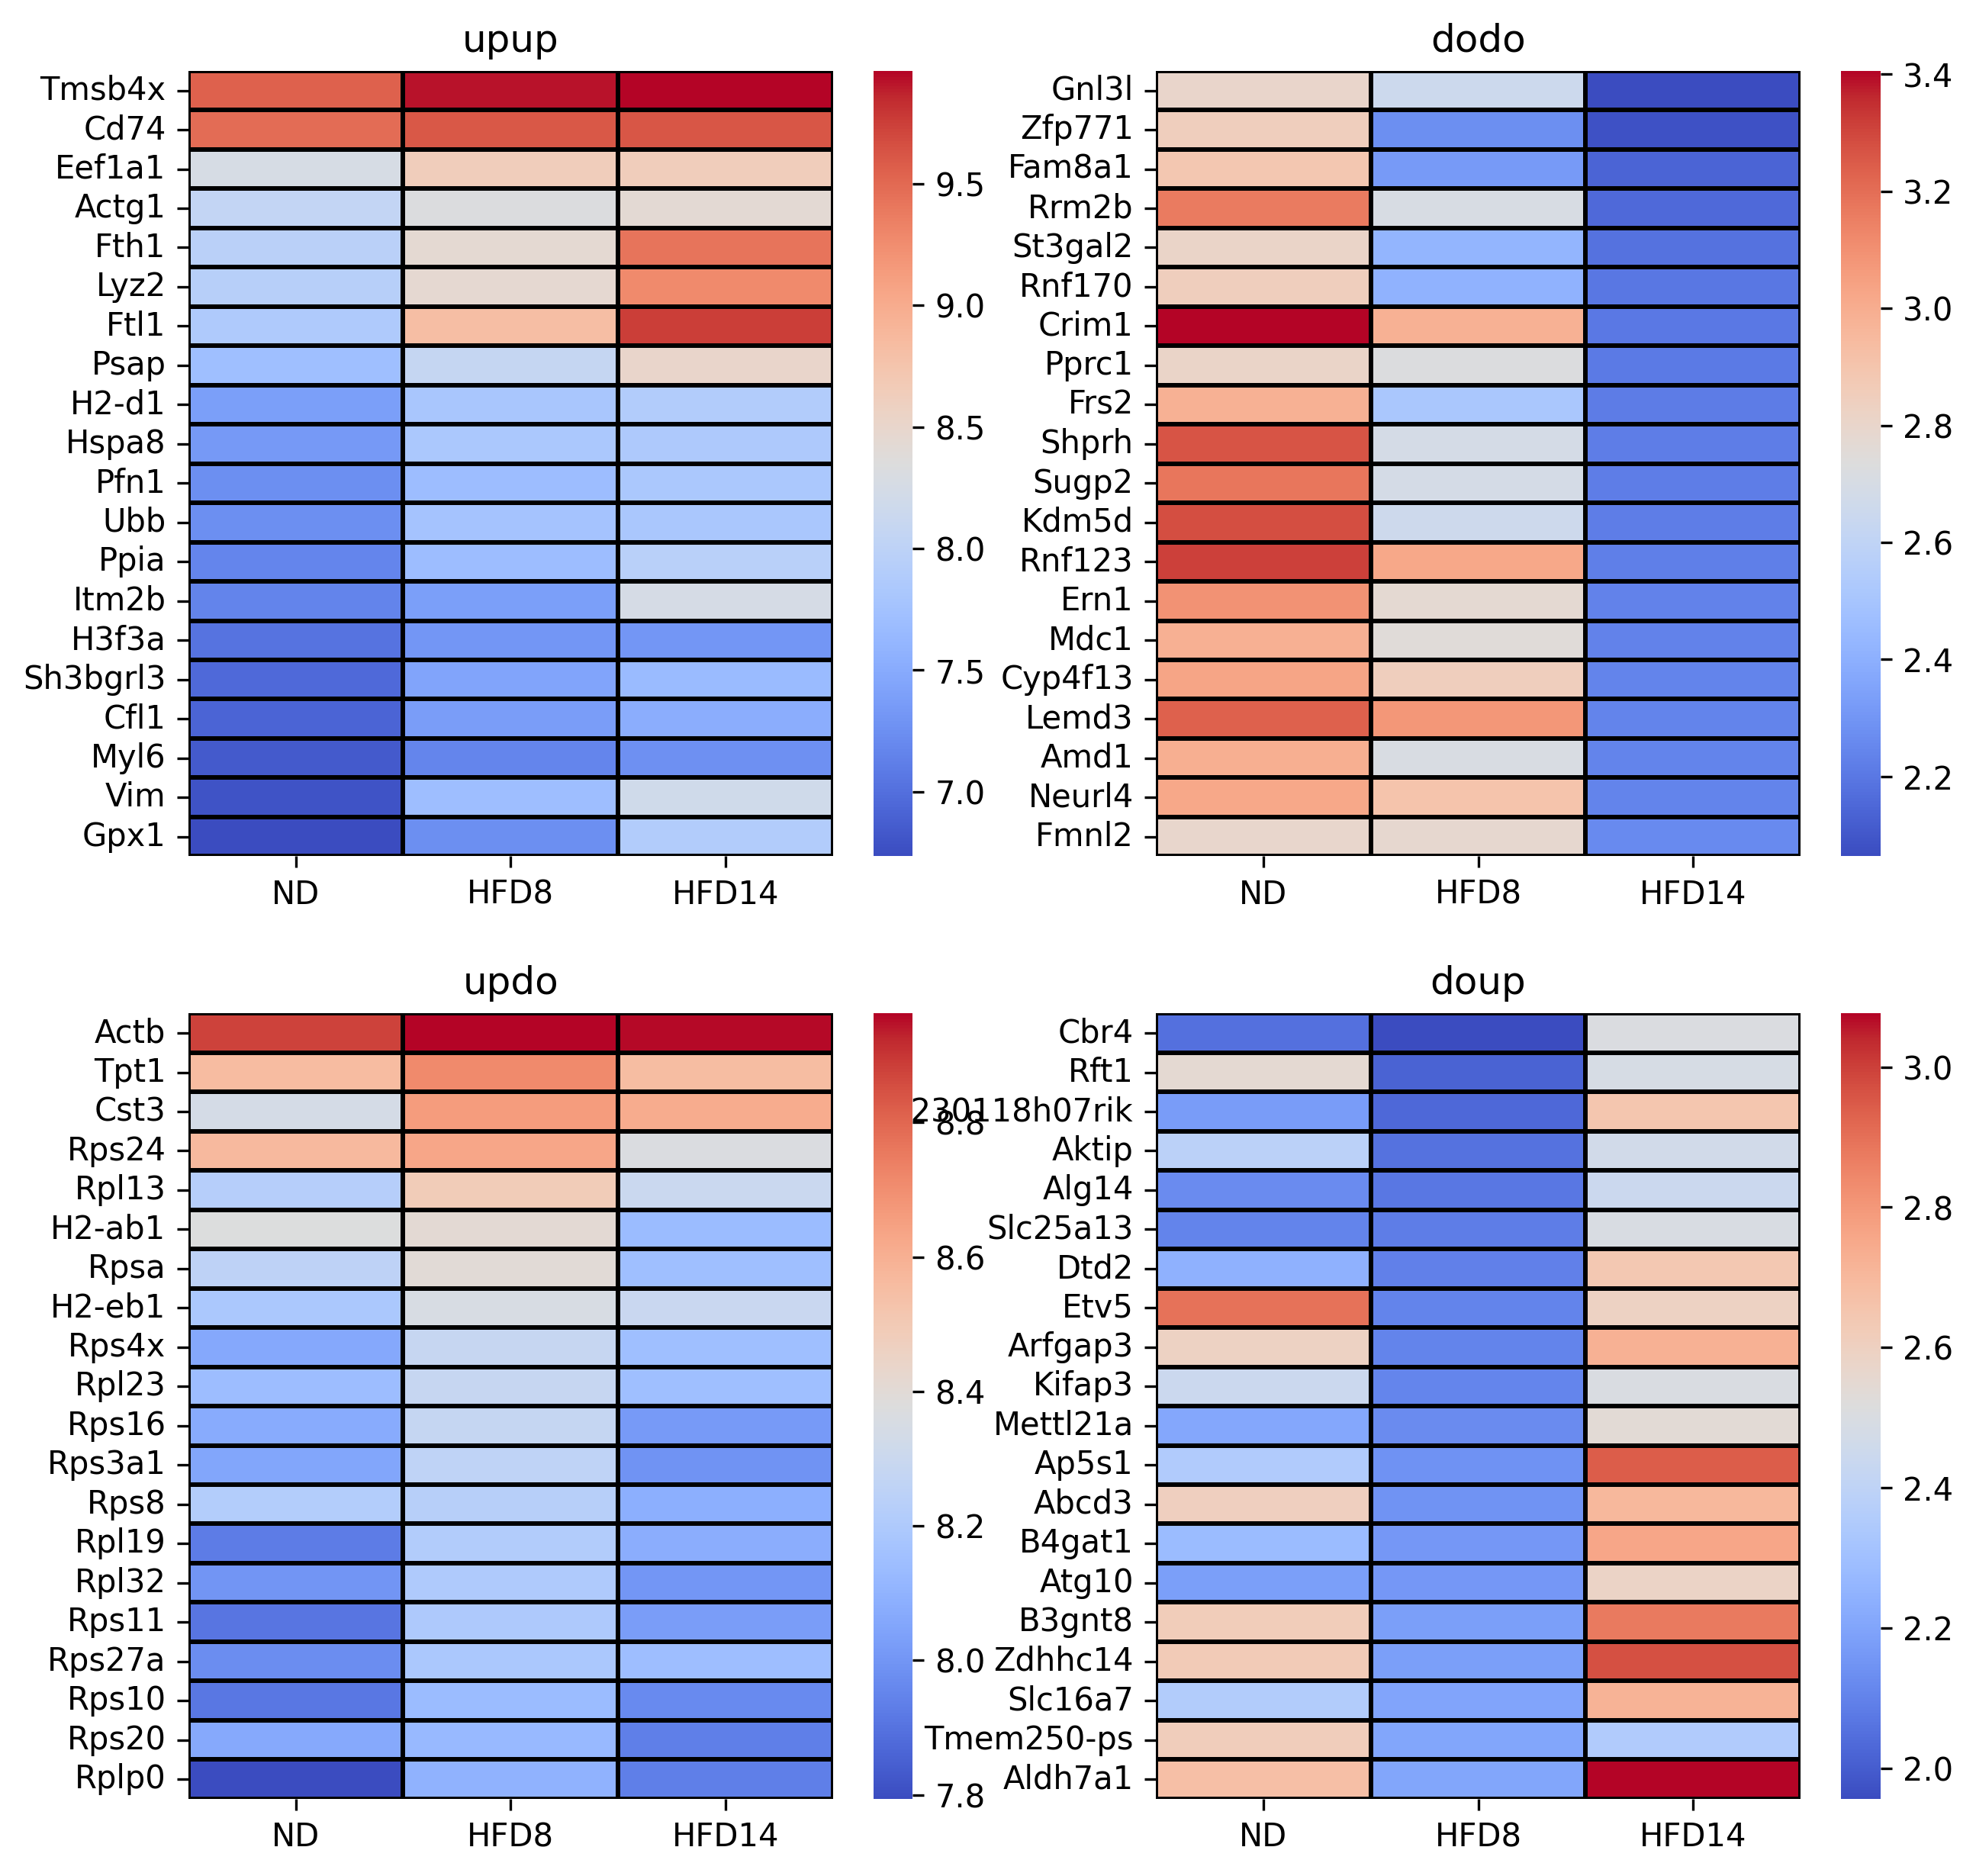

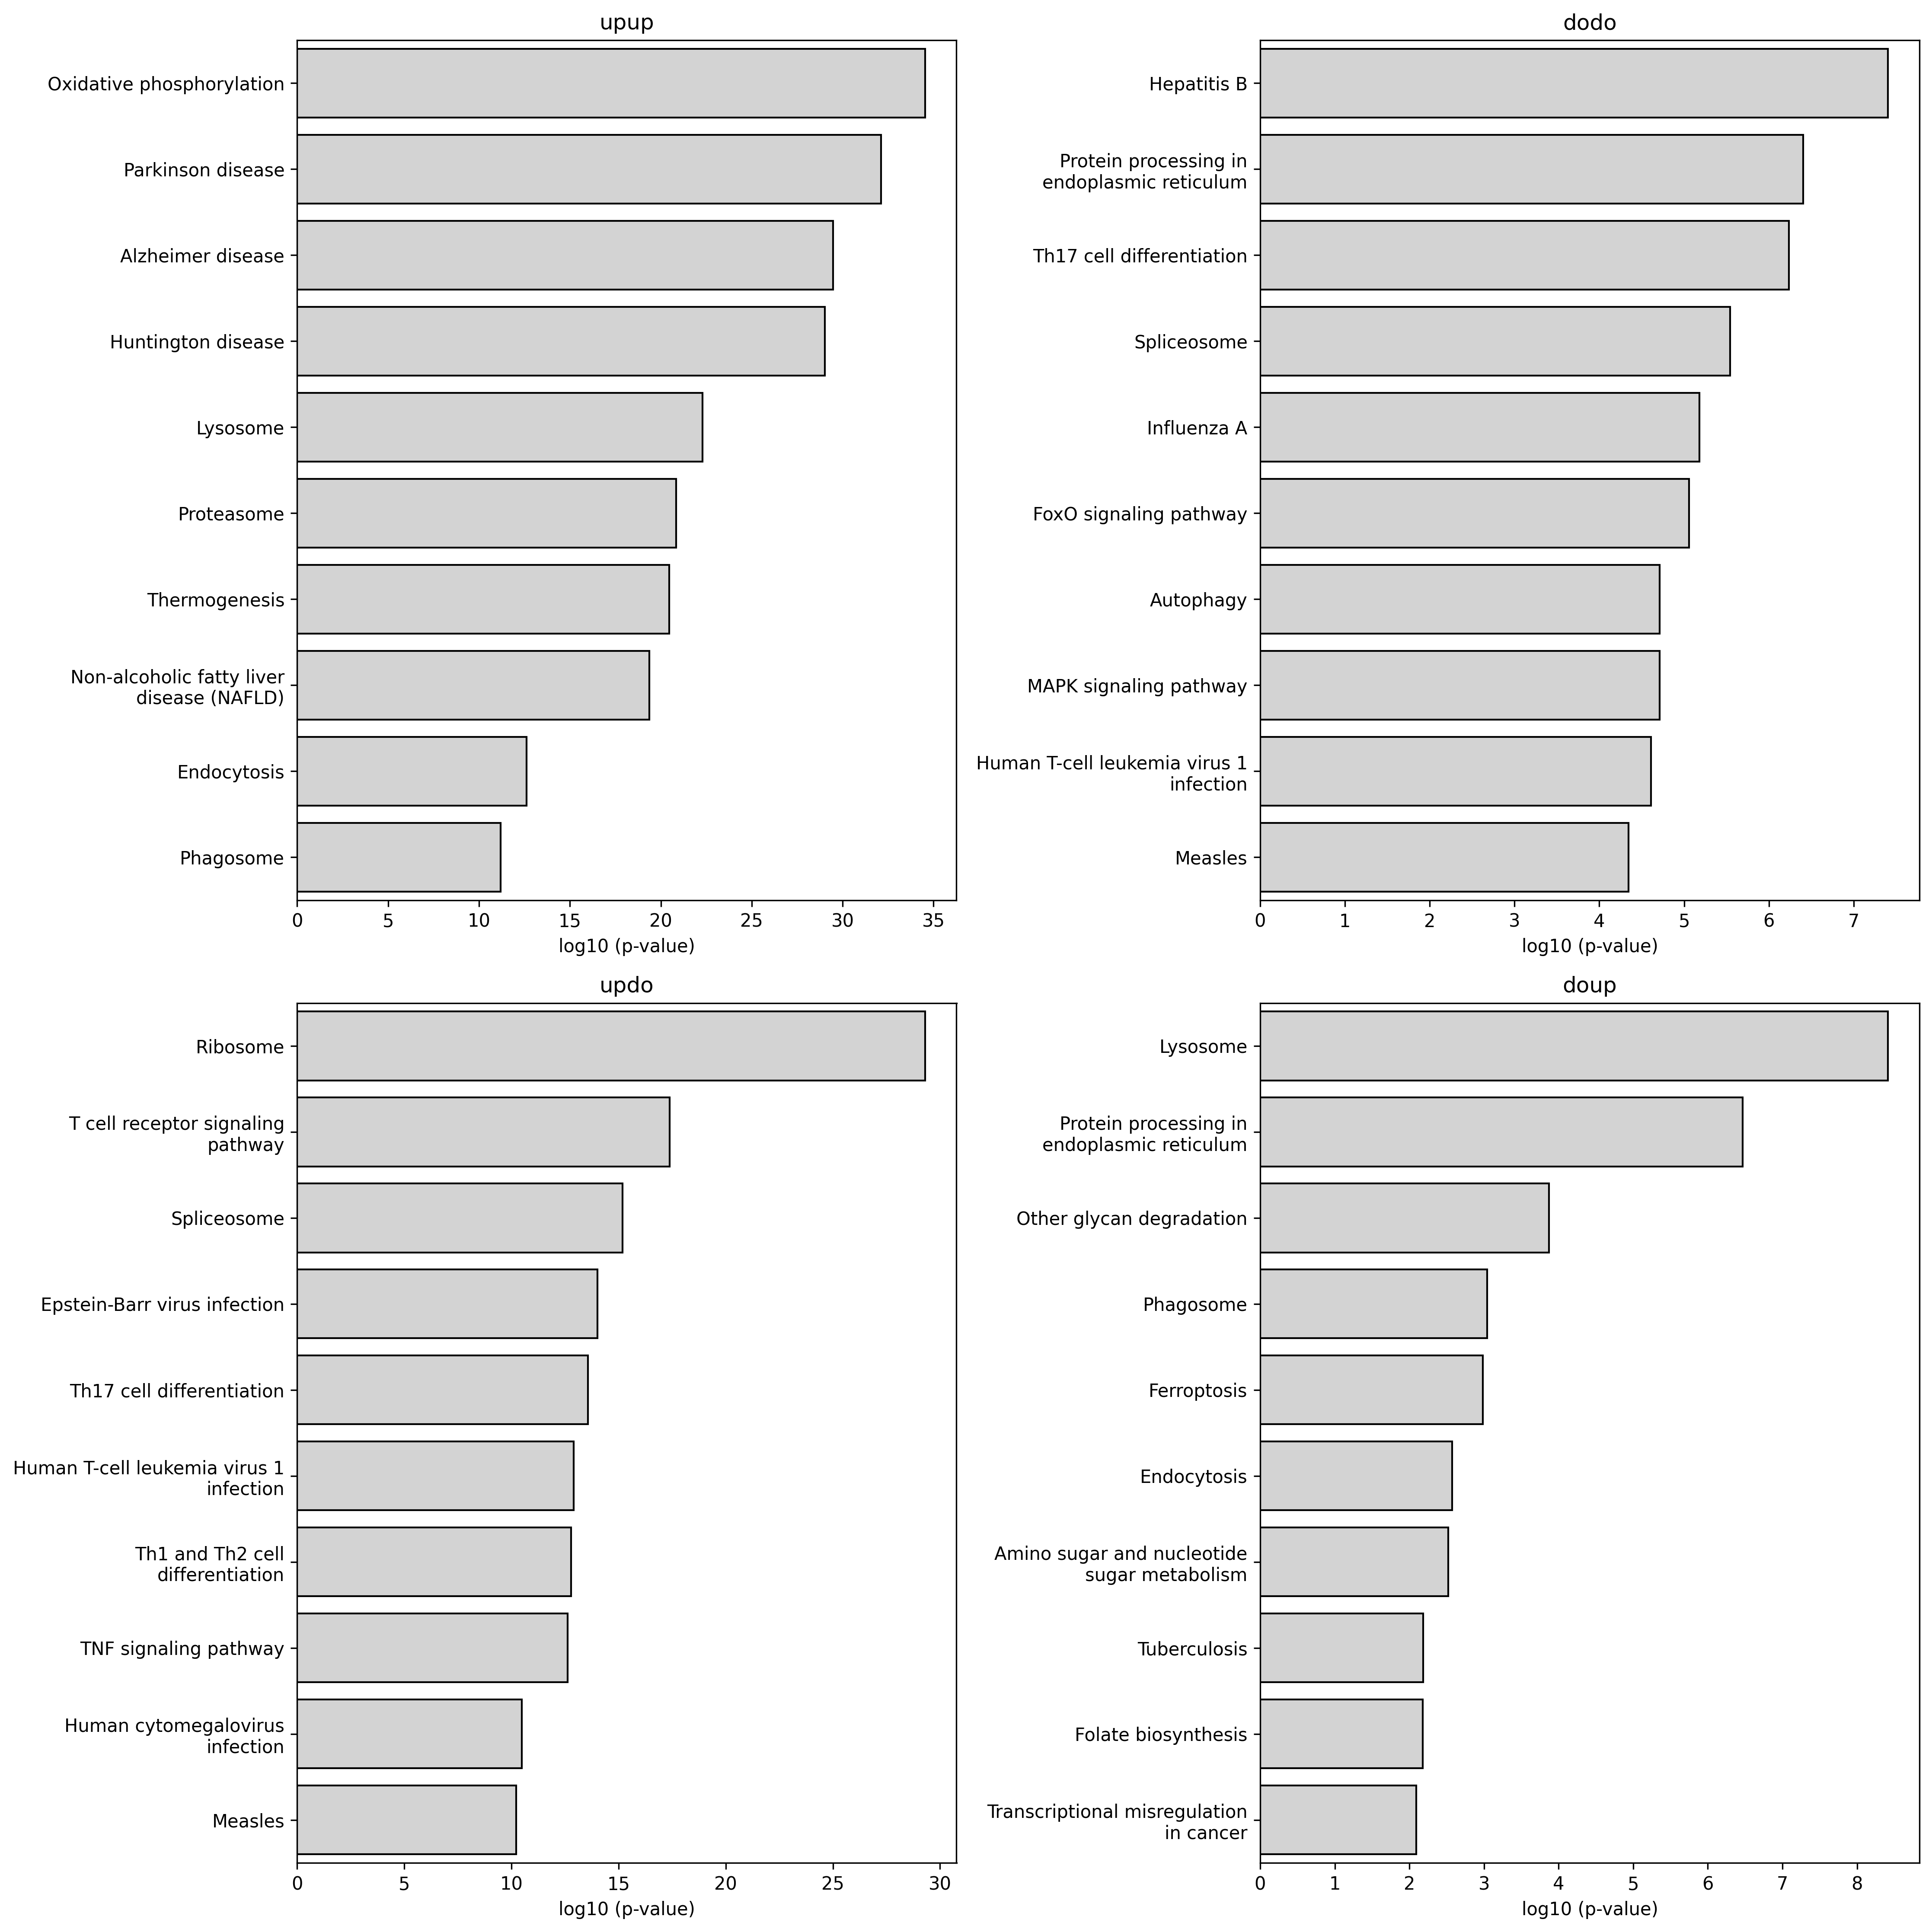

In [12]:
pdf = res2.copy()

# drop genes not in all three times
pdf['geneCount'] = pdf.groupby('gene')['key'].transform('count')
pdf = pdf[pdf['geneCount'] == 3]



plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs2 = plt.subplots(2, 2)
axs2 = axs2.ravel()

top = 20
nPathway = 10

sorts = {
    'upup' : ['ND', False],
    'dodo' : ['HFD14', True],
    'updo' : ['HFD8', False],
    'doup' : ['HFD8', True],
}


for i, dyn in enumerate(res2['dynamics'].unique()):
    ddf = res2[res2['dynamics'] == dyn]
    
    # geneSample = np.random.choice(ddf['gene'], sample, replace=False)
    # ddf = ddf[ddf['gene'].isin(geneSample)]
    
    ddf = ddf.sort_values(by='key', ascending=False)
    
    print(ddf.shape)
    
    ddf['geneName'] = ddf['gene'].apply(lambda x: str(x).lower().capitalize())
    ddf['logExp'] = np.log(ddf['meanExp'])
    # print(ddf['logExp'].describe())
    
    M = pd.pivot_table(ddf, 
                       index=['geneName'],
                       columns=['key'],
                       values='logExp')
    
    M = M[M.columns[::-1]]
    M = M.sort_values(by=sorts[dyn][0], ascending=sorts[dyn][1])
    genes = M.index.to_list()
    sns.heatmap(M.head(top),
                linewidths=1,
                linecolor='k',
                cmap='coolwarm',
                # vmin=1,
                # vmax=10,
                # cbar=False,
                ax=axs[i])
    
    
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(dyn)
    
    # db = 'WikiPathways_2019_Mouse'
    db = 'KEGG_2019_Mouse'
    # db = 'ontology'

    ef = gget.enrichr(genes, database=db)
    ef['logp'] = ef['p_val'].apply(lambda x: -np.log10(x))
    ef['pathName'] = ['\n'.join(wrap(l,  width=30)) for l in ef['path_name']]

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.facecolor'] = "w"
    plt.rcParams['figure.figsize'] = 4, 4

    sns.barplot(data=ef.head(nPathway), 
                x='logp', 
                y='pathName', 
                color='lightgrey',
                edgecolor='k',  
                ax=axs2[i])
    
    axs2[i].set_ylabel("")
    axs2[i].set_xlabel("log10 (p-value)")
    axs2[i].set_title(dyn)

plt.tight_layout()
plt.tight_layout()

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [13]:
""" the same for LR pairs """

allLR = list(set(lr['ligand'].to_list() + lr['receptor'].to_list()))


dynTypes = {
    'upup' : upup,
    'dodo' : dodo,
    'updo' : updo,
    'doup' : doup,
}

res2 = []

for key in keys:
    kdf = cData[key]
    
    for dynName, dynDf in dynTypes.items():
        genes = dynDf['gene'].unique()
        genes = [x for x in genes if x in allLR]
                
        meanExp = kdf[genes].mean(axis=0).reset_index(drop=False)
        meanExp.columns = ['gene', 'meanExp']
        meanExp['key'] = key
        meanExp['dynamics'] = dynName
        
        res2.append(meanExp)
    
res2 = pd.concat(res2, ignore_index=True)
res2.head()

gene     meanExp key dynamics
0     CD48  135.229411  ND     upup
1     CD93   43.147383  ND     upup
2     PLTP  235.005710  ND     upup
3     GNAS  464.760301  ND     upup
4  ATP6AP2   70.223340  ND     upup

(201, 4)


Wed Feb 22 14:52:59 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


(114, 4)


Wed Feb 22 14:53:00 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


(153, 4)


Wed Feb 22 14:53:00 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


(105, 4)


Wed Feb 22 14:53:01 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


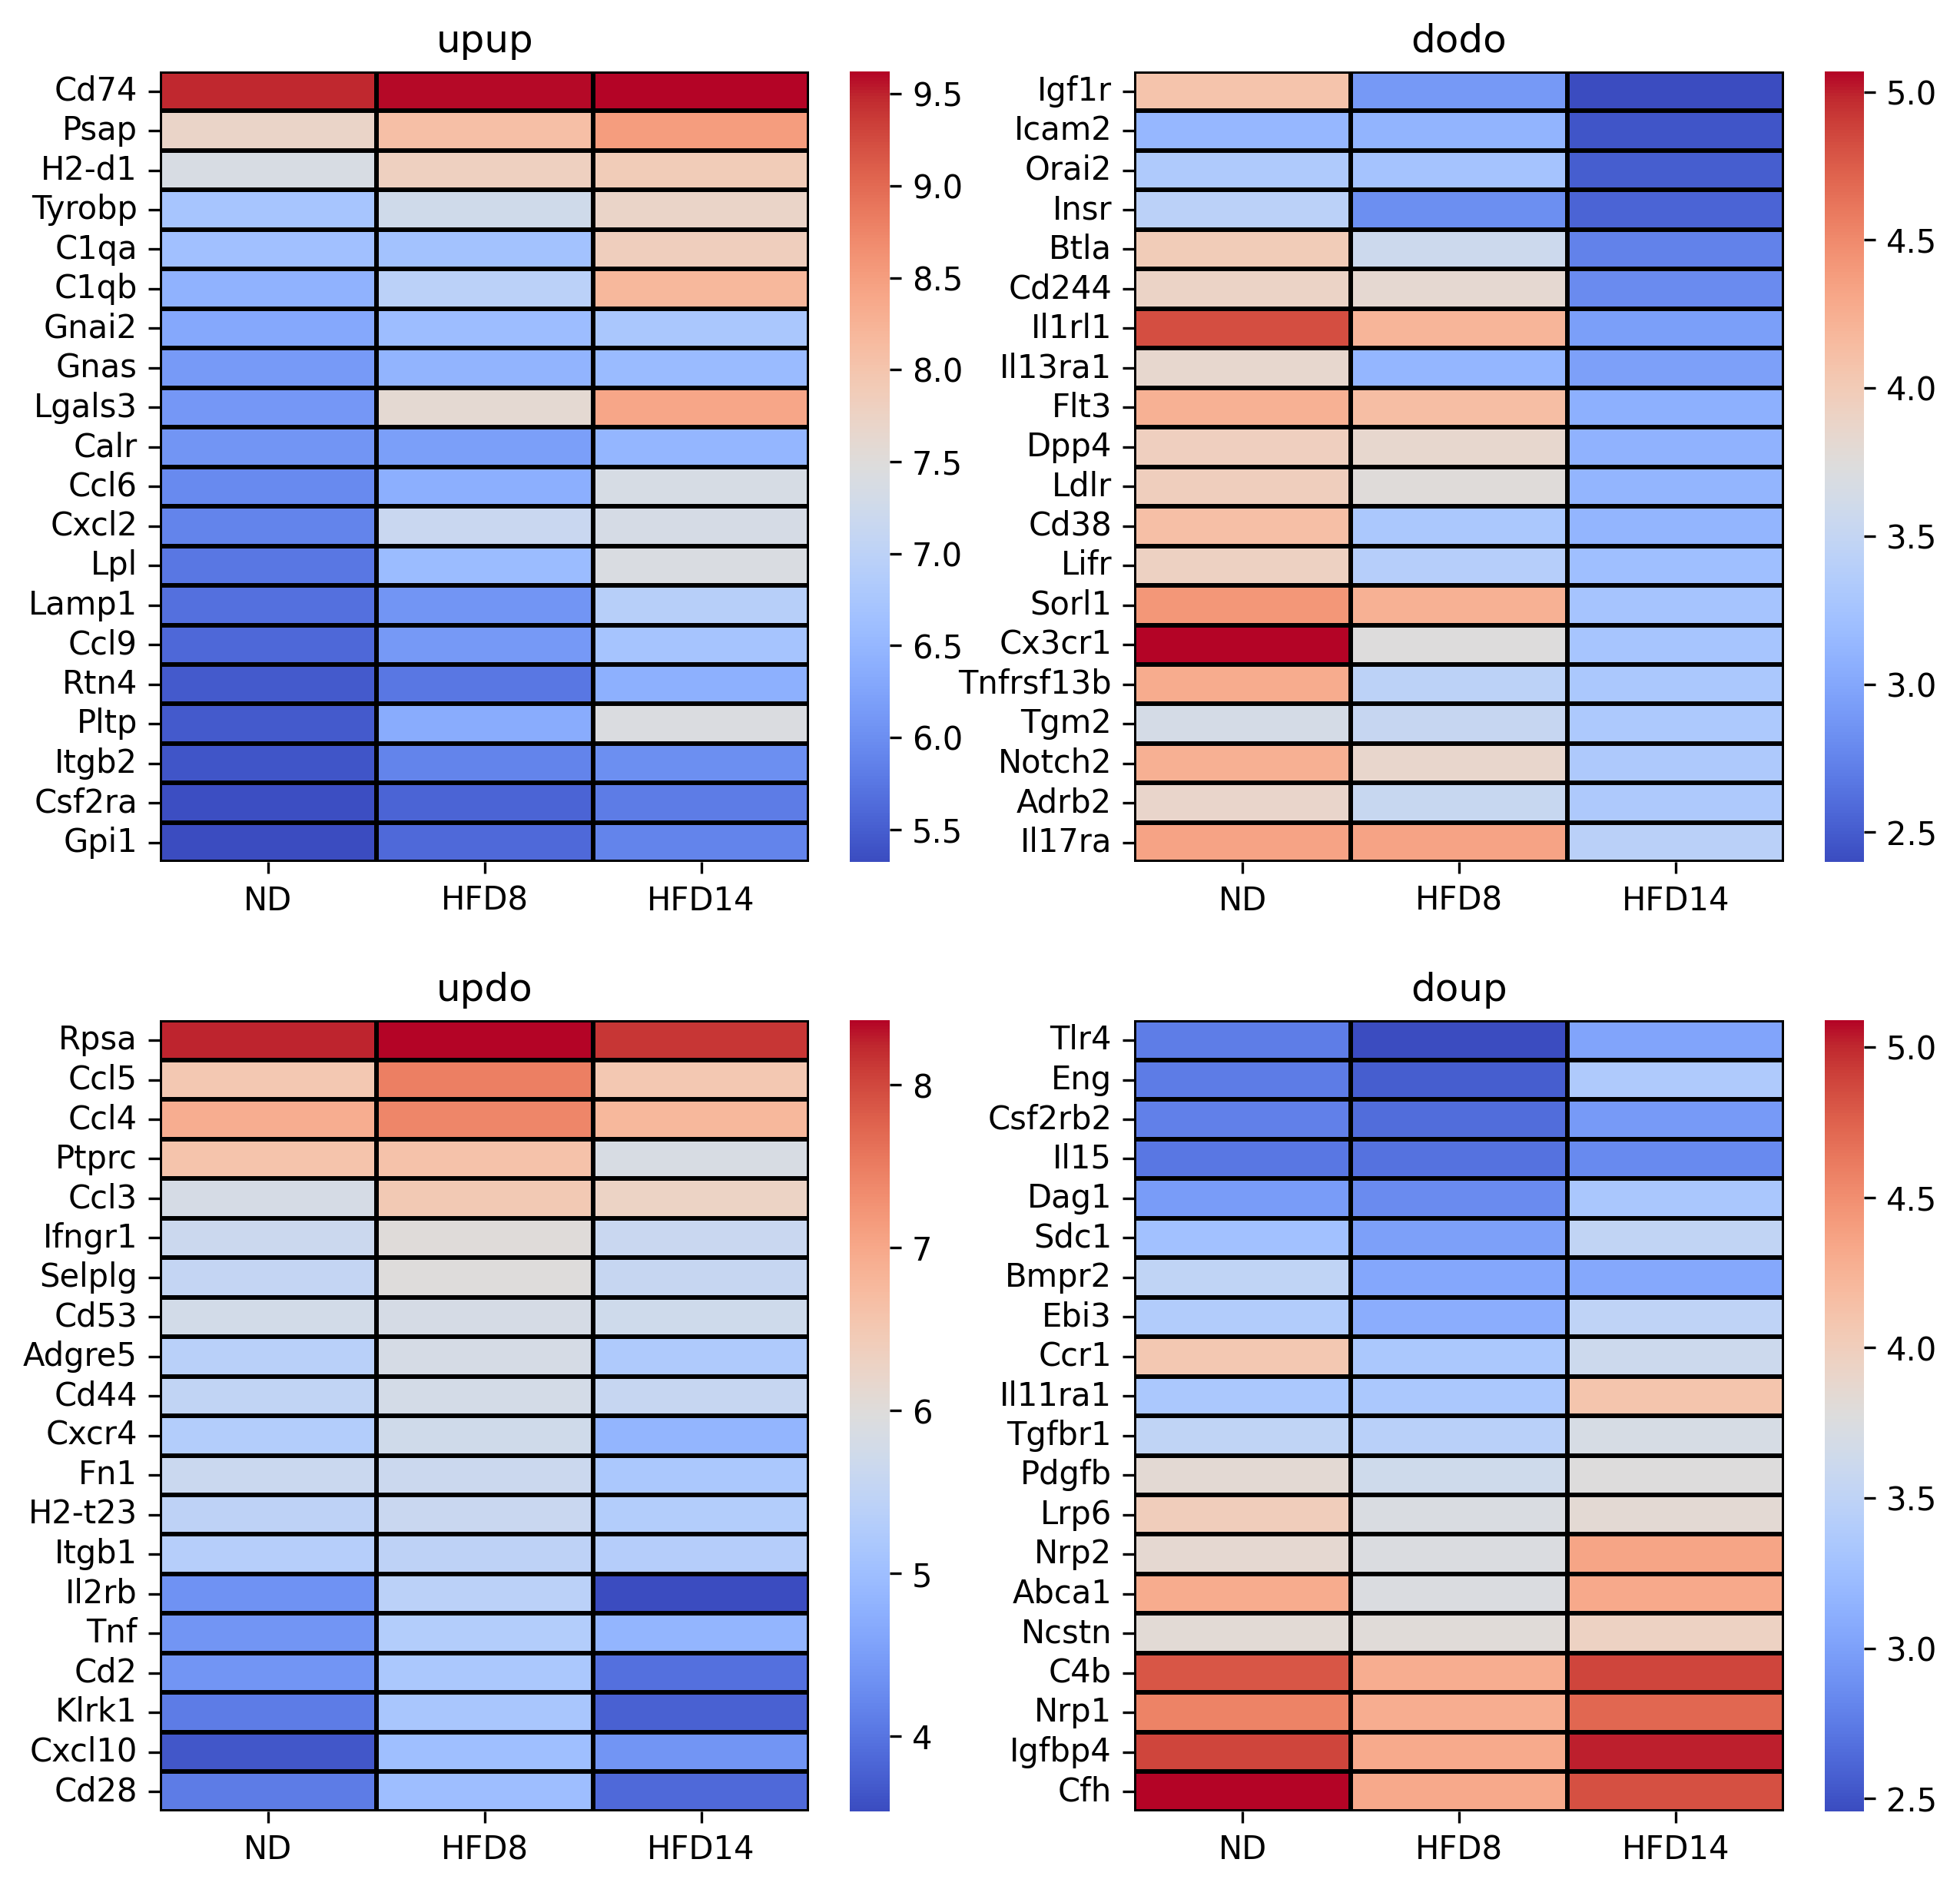

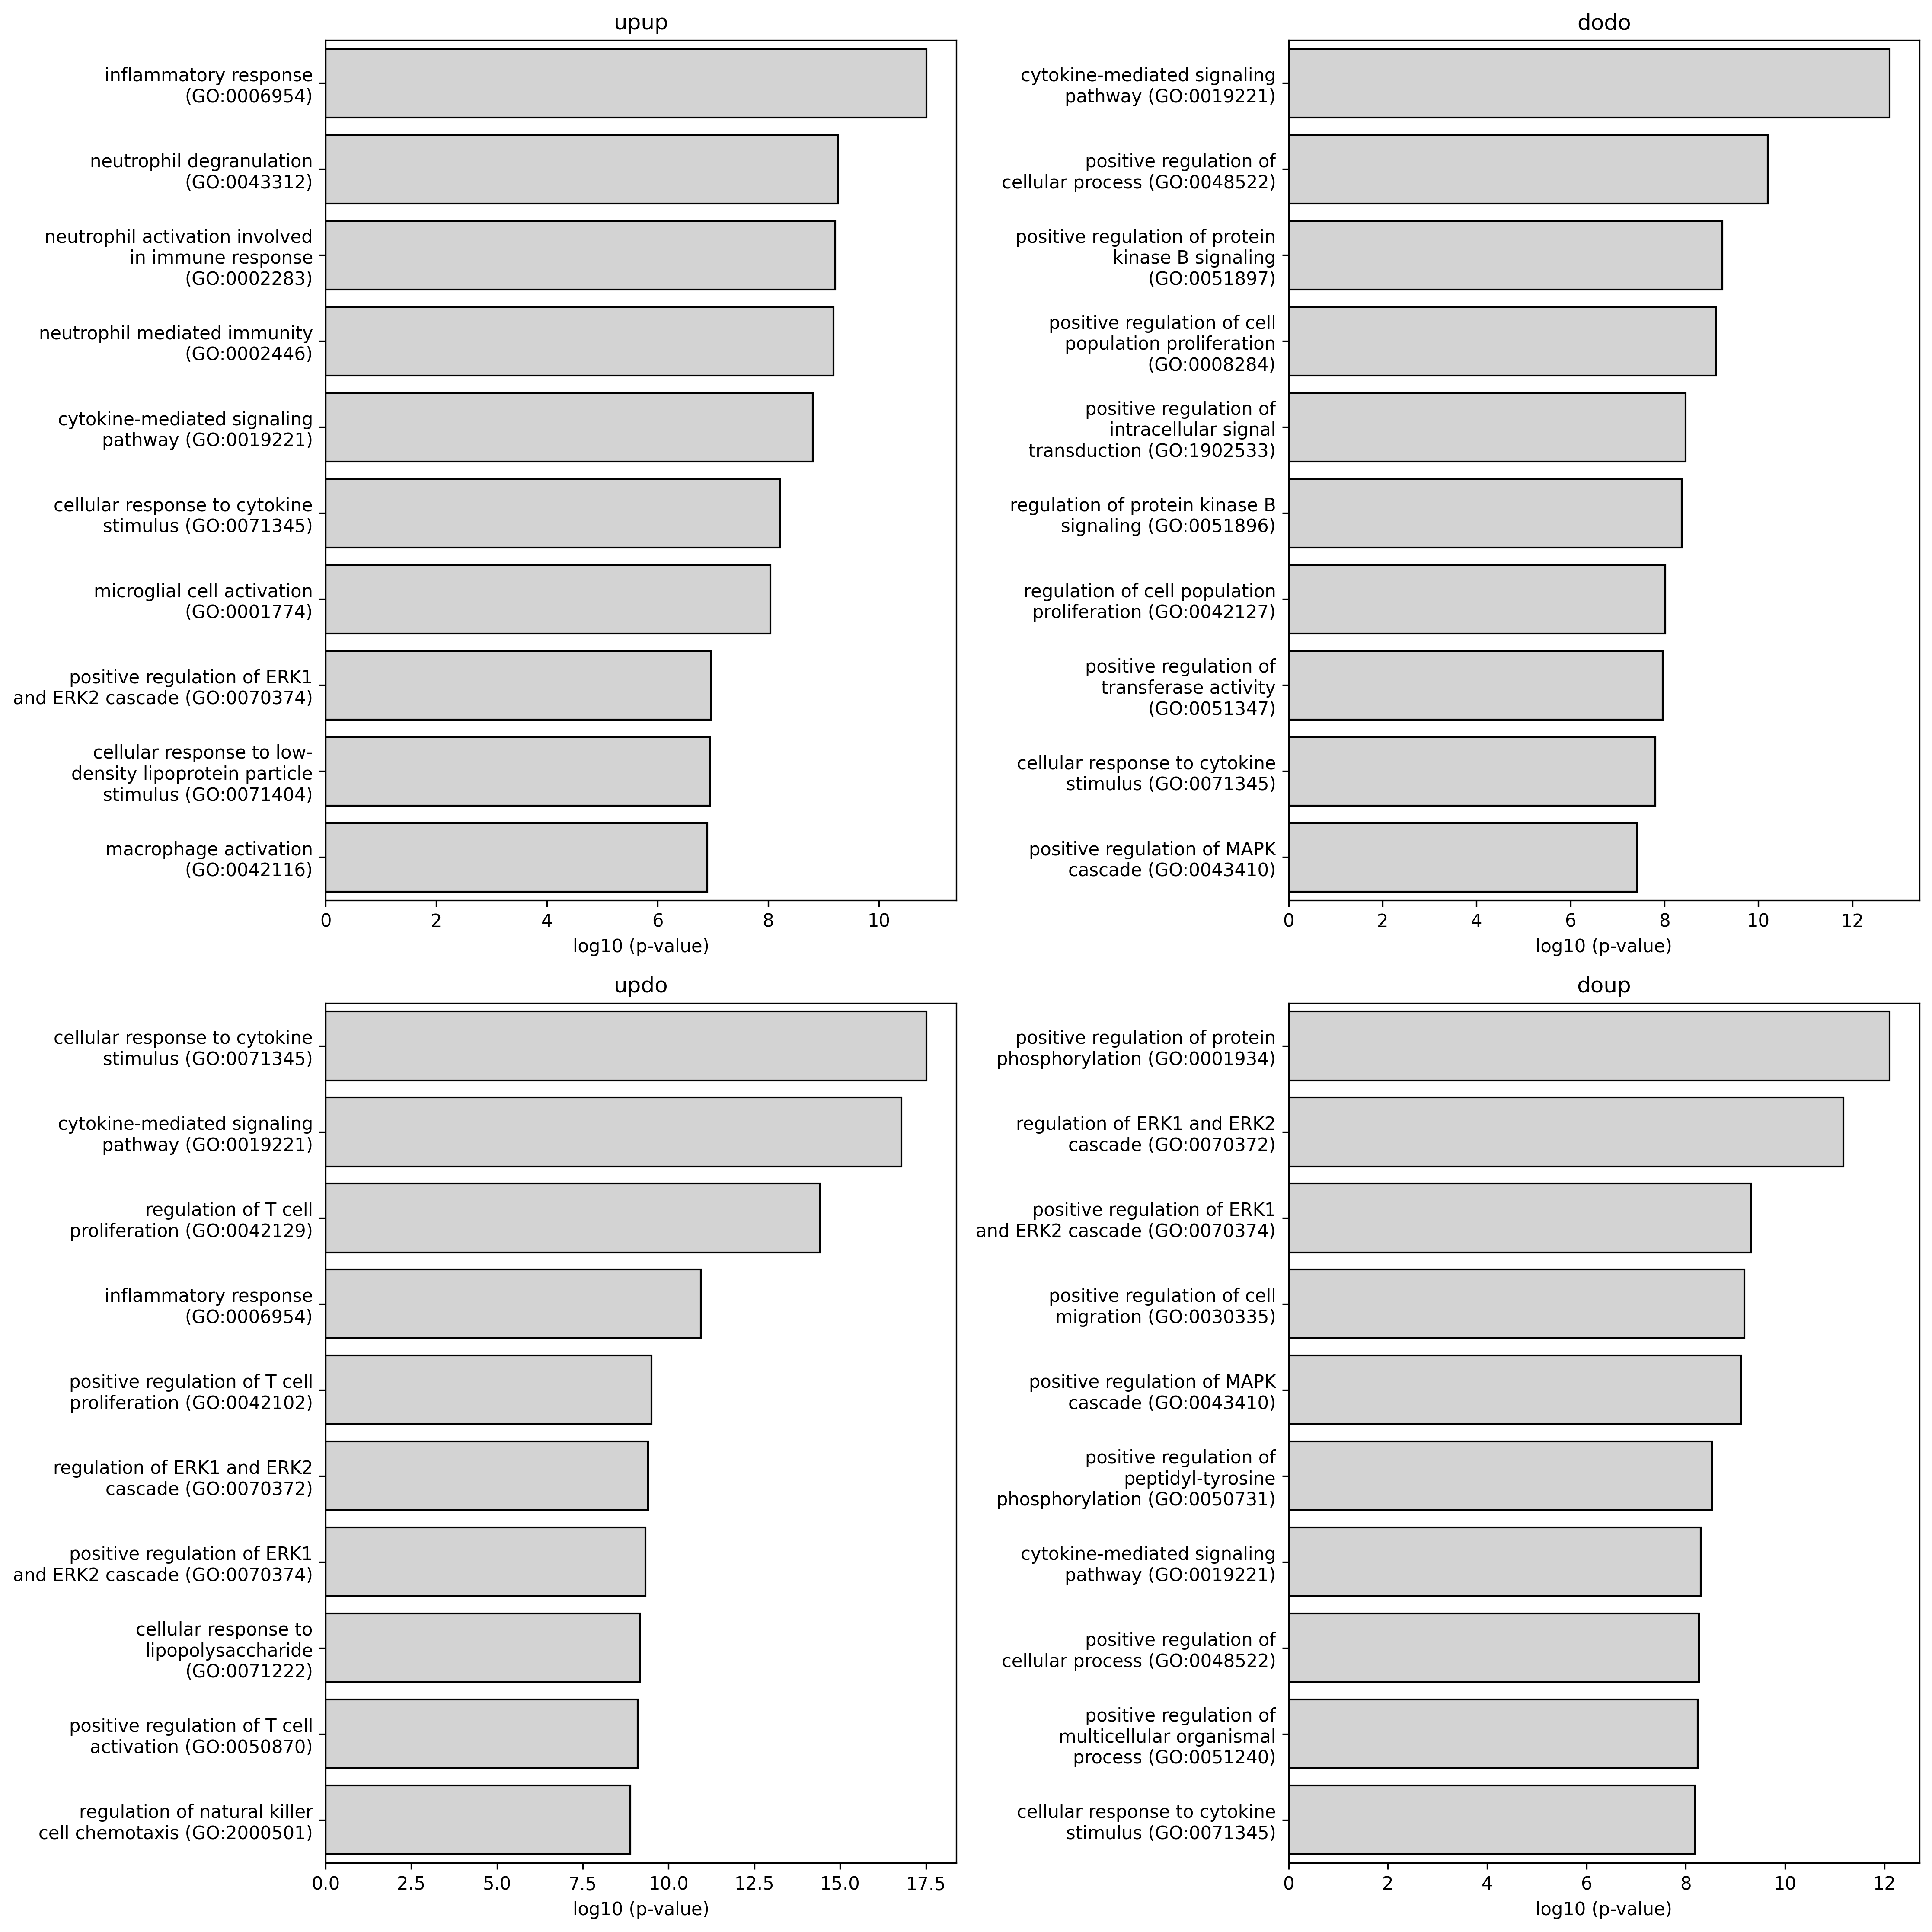

In [16]:
pdf = res2.copy()

# drop genes not in all three times
pdf['geneCount'] = pdf.groupby('gene')['key'].transform('count')
pdf = pdf[pdf['geneCount'] == 3]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs2 = plt.subplots(2, 2)
axs2 = axs2.ravel()

top = 20
nPathway = 10

sorts = {
    'upup' : ['ND', False],
    'dodo' : ['HFD14', True],
    'updo' : ['HFD8', False],
    'doup' : ['HFD8', True],
}


for i, dyn in enumerate(res2['dynamics'].unique()):
    ddf = res2[res2['dynamics'] == dyn]
    
    # geneSample = np.random.choice(ddf['gene'], sample, replace=False)
    # ddf = ddf[ddf['gene'].isin(geneSample)]
    
    ddf = ddf.sort_values(by='key', ascending=False)
    
    print(ddf.shape)
    
    ddf['geneName'] = ddf['gene'].apply(lambda x: str(x).lower().capitalize())
    ddf['logExp'] = np.log(ddf['meanExp'])
    # print(ddf['logExp'].describe())
    
    M = pd.pivot_table(ddf, 
                       index=['geneName'],
                       columns=['key'],
                       values='logExp')
    
    M = M[M.columns[::-1]]
    M = M.sort_values(by=sorts[dyn][0], ascending=sorts[dyn][1])
    genes = M.index.to_list()
    sns.heatmap(M.head(top),
                linewidths=1,
                linecolor='k',
                cmap='coolwarm',
                # vmin=1,
                # vmax=10,
                # cbar=False,
                ax=axs[i])
    
    
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(dyn)
    
    # db = 'WikiPathways_2019_Mouse'
    # db = 'KEGG_2019_Mouse'
    db = 'ontology'

    ef = gget.enrichr(genes, database=db)
    ef['logp'] = ef['p_val'].apply(lambda x: -np.log10(x))
    ef['pathName'] = ['\n'.join(wrap(l,  width=30)) for l in ef['path_name']]

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.facecolor'] = "w"
    plt.rcParams['figure.figsize'] = 4, 4

    sns.barplot(data=ef.head(nPathway), 
                x='logp', 
                y='pathName', 
                color='lightgrey',
                edgecolor='k',  
                ax=axs2[i])
    
    axs2[i].set_ylabel("")
    axs2[i].set_xlabel("log10 (p-value)")
    axs2[i].set_title(dyn)

plt.tight_layout()
plt.tight_layout()

In [ ]:
break

In [21]:
""" now for specific cell types """

ctype = "Macrophages"

t = 0.05 # ten percent of the cells
res = []

macattack = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

# prepare the data
keys = ['ND', 'HFD8', 'HFD14']
cData = {}

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf['metatype'] = np.where(lf['cellType'].isin(macattack), 'Macrophages', lf['cellType'])
    
    mask = (lf['metatype'] == ctype)
    cellIds = lf[mask]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    
    rbin = rf.astype(bool).astype(int)
    colSums = rbin.sum(axis=0)
    colSums = colSums / len(rbin)
    colInd = np.where(colSums > t)[0]
    rf = rf[rf.columns[colInd]]
    print(key, rf.shape)

    cData[key] = rf



ND (359, 9302)
HFD8 (2188, 8784)
HFD14 (3884, 8503)


In [22]:
res = []

comps = [
    ('ND', 'HFD8'),
    # ('ND', 'HFD14'),
    ('HFD8', 'HFD14'),
]

for ikey, jkey in comps:        
    irf = cData[ikey]
    jrf = cData[jkey]

    for gene in irf.columns:
        if gene in irf.columns and gene in jrf.columns:
            score, pval = scipy.stats.ranksums(irf[gene], 
                                               jrf[gene],
                                               alternative='two-sided')

            lfc = np.log2(jrf[gene].mean()) - np.log2(irf[gene].mean())

            row = {
                'ikey' : ikey,
                'jkey' : jkey,
                'gene' : gene,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc,
                'meani' : irf[gene].mean(),
                'meanj' : jrf[gene].mean(),
                
            }

            res.append(row)
        
        
res = pd.DataFrame(res)
res.head()

ikey  jkey     gene     score      pval  log2foldchange      meani  \
0   ND  HFD8   MRPL15 -0.219094  0.826577        0.290079  43.610807   
1   ND  HFD8   LYPLA1  0.603892  0.545916        0.046895  30.629282   
2   ND  HFD8    TCEA1  4.170290  0.000030       -0.360996  90.627311   
3   ND  HFD8  ATP6V1H -4.592952  0.000004        0.973307  49.499891   
4   ND  HFD8   RB1CC1  3.706705  0.000210       -0.526736  84.825989   

       meanj  
0  53.323262  
1  31.641243  
2  70.564835  
3  97.184941  
4  58.879687

In [23]:
alpha = 0.01
pdf = res.copy()
pdf['key'] = pdf['ikey'] + "_" + pdf['jkey']

pdf['sign'] = np.sign(pdf['log2foldchange'])
pdf['sumSign'] = pdf.groupby('gene')['sign'].transform('sum')
pdf['fsign'] = pdf.groupby('gene')['sign'].transform('first')
pdf['lsign'] = pdf.groupby('gene')['sign'].transform('last')
pdf['diffSign'] = pdf['fsign'] - pdf['lsign']

pdf = pdf[pdf['pval'] < alpha]

upup = pdf[pdf['sumSign'] == 2]
print(f"{upup.shape=}")

dodo = pdf[pdf['sumSign'] == -2]
print(f"{dodo.shape=}")

updo = pdf[pdf['diffSign'] == 2]
print(f"{updo.shape=}")

doup = pdf[pdf['diffSign'] == -2]
print(f"{doup.shape=}")


upup.shape=(2079, 14)
dodo.shape=(2261, 14)
updo.shape=(759, 14)
doup.shape=(518, 14)


ikey  jkey     gene     score      pval  log2foldchange      meani  \
2   ND  HFD8    TCEA1  4.170290  0.000030       -0.360996  90.627311   
3   ND  HFD8  ATP6V1H -4.592952  0.000004        0.973307  49.499891   
4   ND  HFD8   RB1CC1  3.706705  0.000210       -0.526736  84.825989   
5   ND  HFD8   PCMTD1  3.231544  0.001231       -0.516097  63.922796   
7   ND  HFD8   VCPIP1  3.483197  0.000495       -0.157191  44.132283   

       meanj      key  sign  sumSign  fsign  lsign  diffSign  
2  70.564835  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0  
3  97.184941  ND_HFD8   1.0      0.0    1.0   -1.0       2.0  
4  58.879687  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0  
5  44.698728  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0  
7  39.576484  ND_HFD8  -1.0     -2.0   -1.0   -1.0       0.0

In [24]:
""" the same for LR pairs """

allLR = list(set(lr['ligand'].to_list() + lr['receptor'].to_list()))


dynTypes = {
    'upup' : upup,
    'dodo' : dodo,
    'updo' : updo,
    'doup' : doup,
}

res2 = []

for key in keys:
    kdf = cData[key]
    
    for dynName, dynDf in dynTypes.items():
        genes = dynDf['gene'].unique()
        genes = [x for x in genes if x in allLR]
                
        meanExp = kdf[genes].mean(axis=0).reset_index(drop=False)
        meanExp.columns = ['gene', 'meanExp']
        meanExp['key'] = key
        meanExp['dynamics'] = dynName
        
        res2.append(meanExp)
    
res2 = pd.concat(res2, ignore_index=True)
res2.head()

gene     meanExp key dynamics
0   NRP2   77.681981  ND     upup
1  SIRPA  329.413520  ND     upup
2   CD93   80.695598  ND     upup
3   PLTP  603.468391  ND     upup
4   GNAS  421.179962  ND     upup

(195, 4)


Wed Feb 22 15:50:24 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


(171, 4)


Wed Feb 22 15:50:25 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


(87, 4)


Wed Feb 22 15:50:25 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


(78, 4)


Wed Feb 22 15:50:26 2023 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.


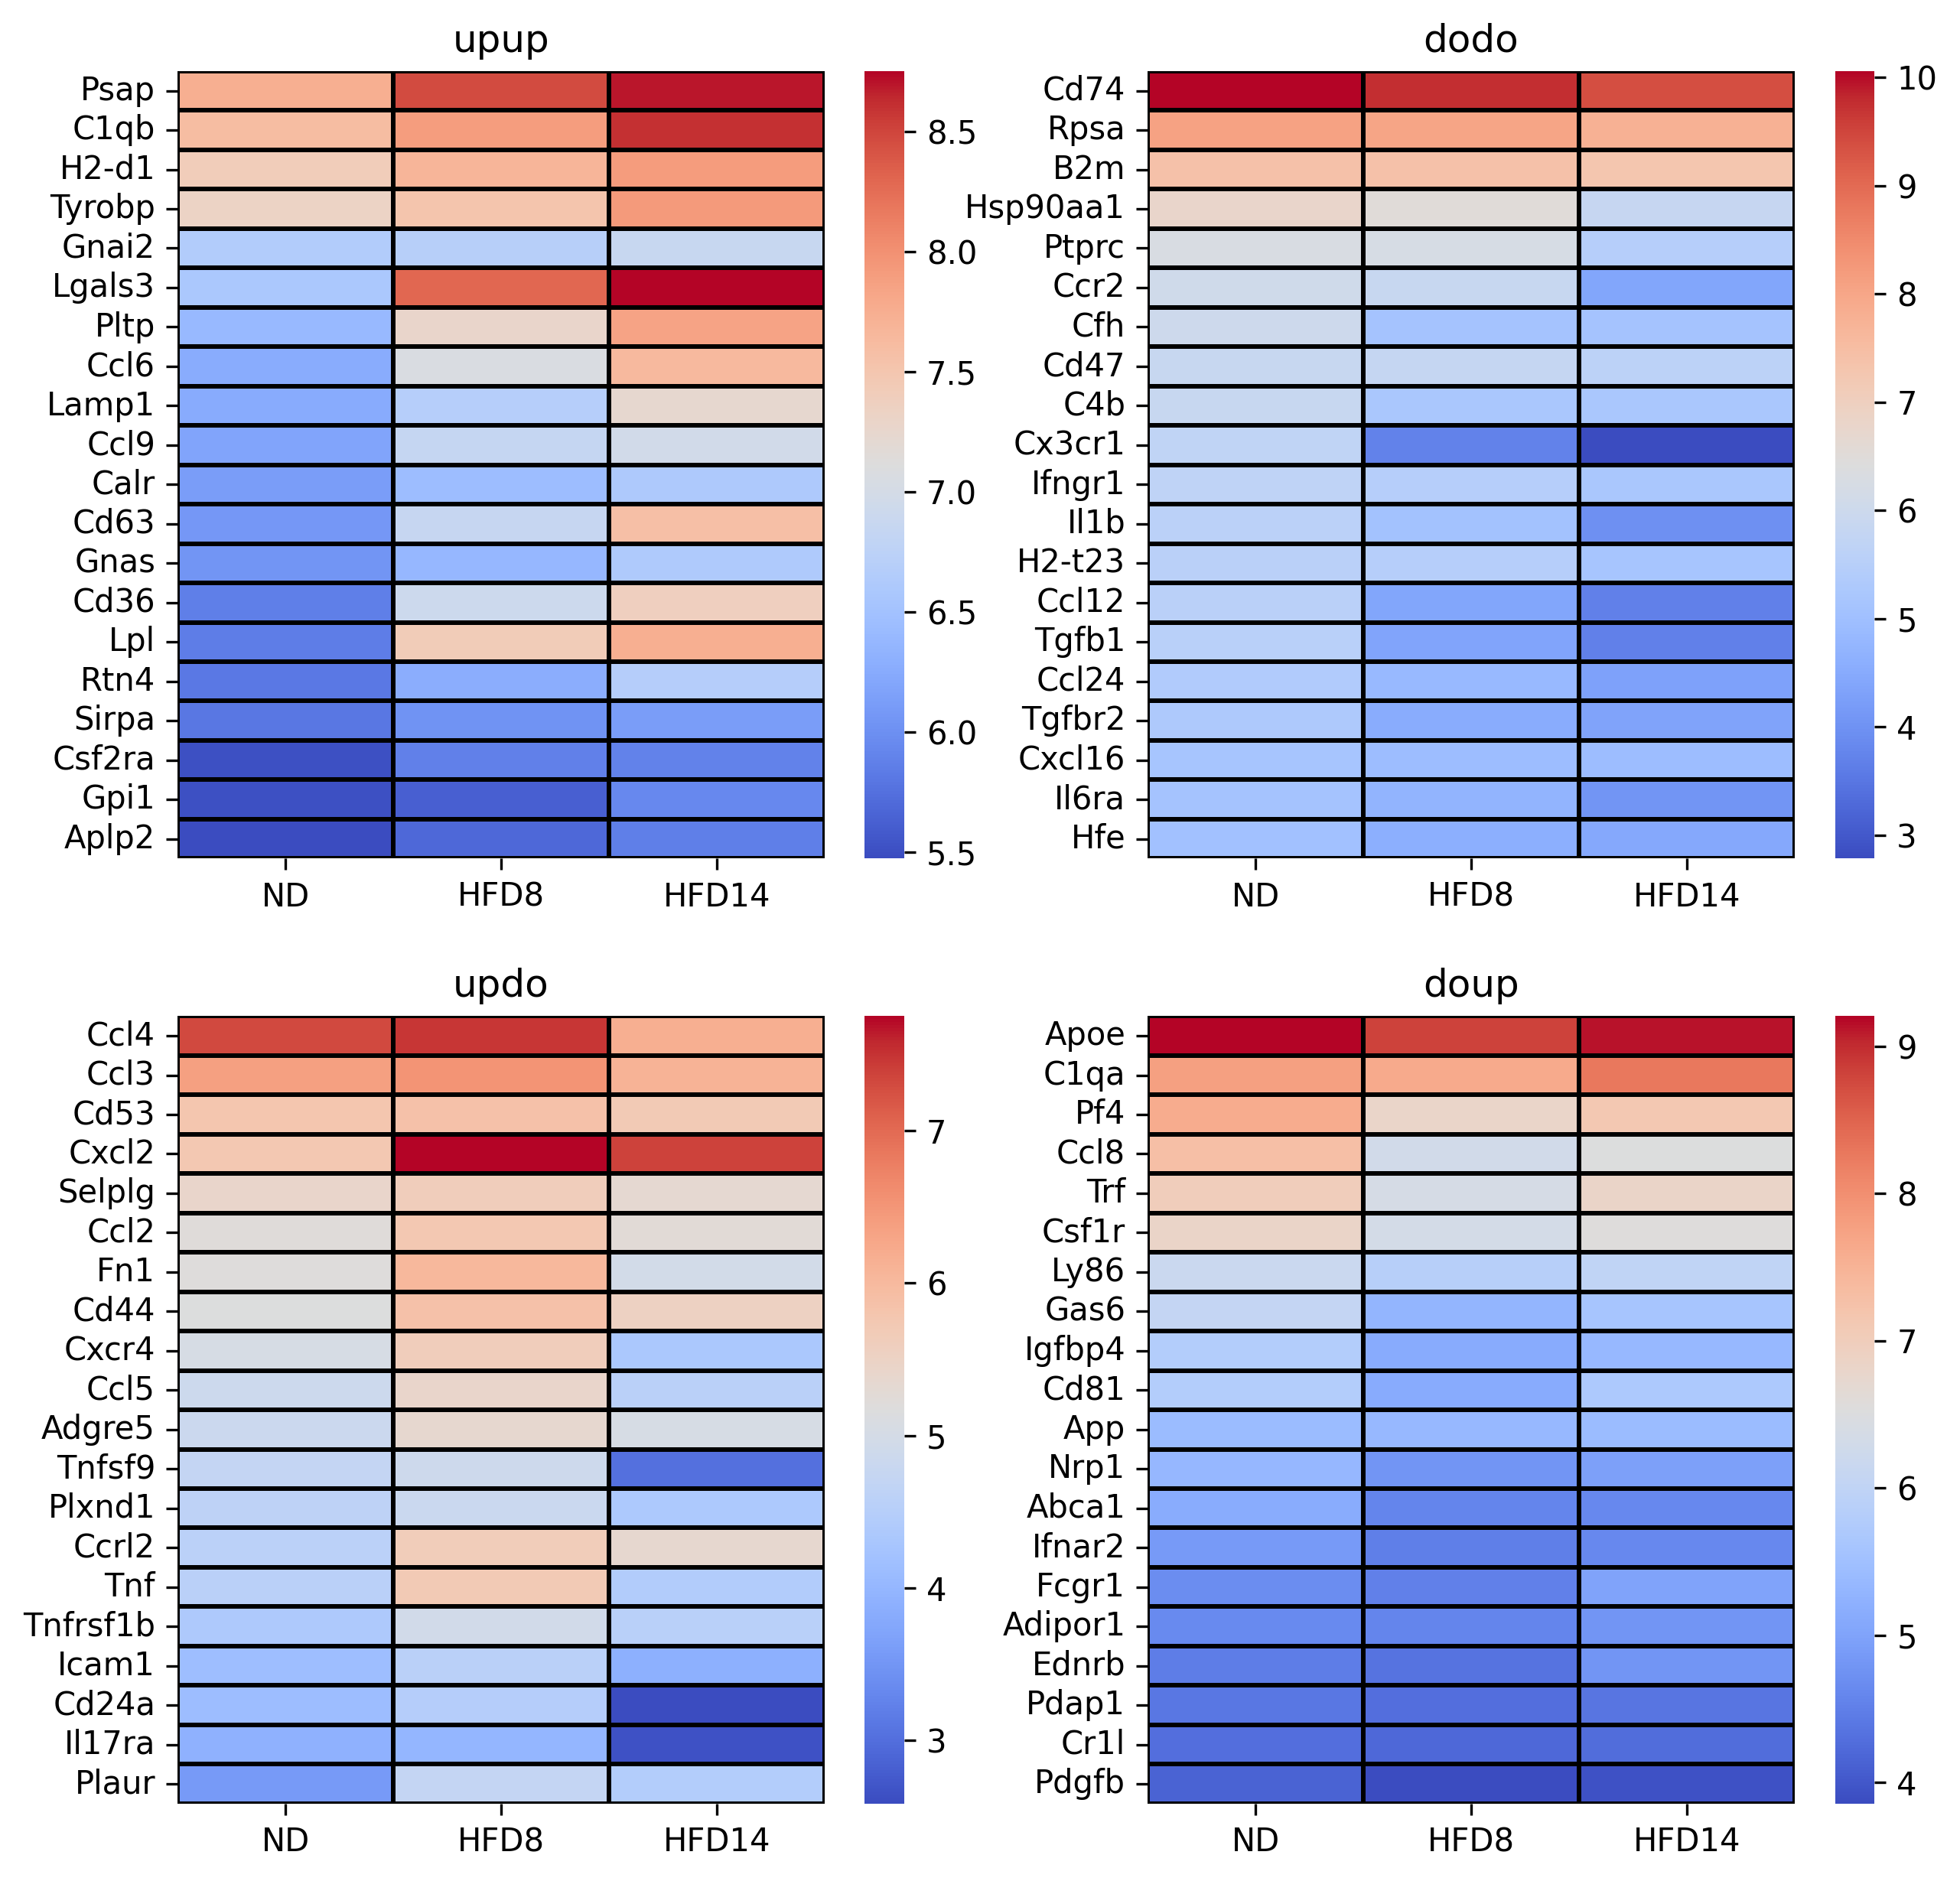

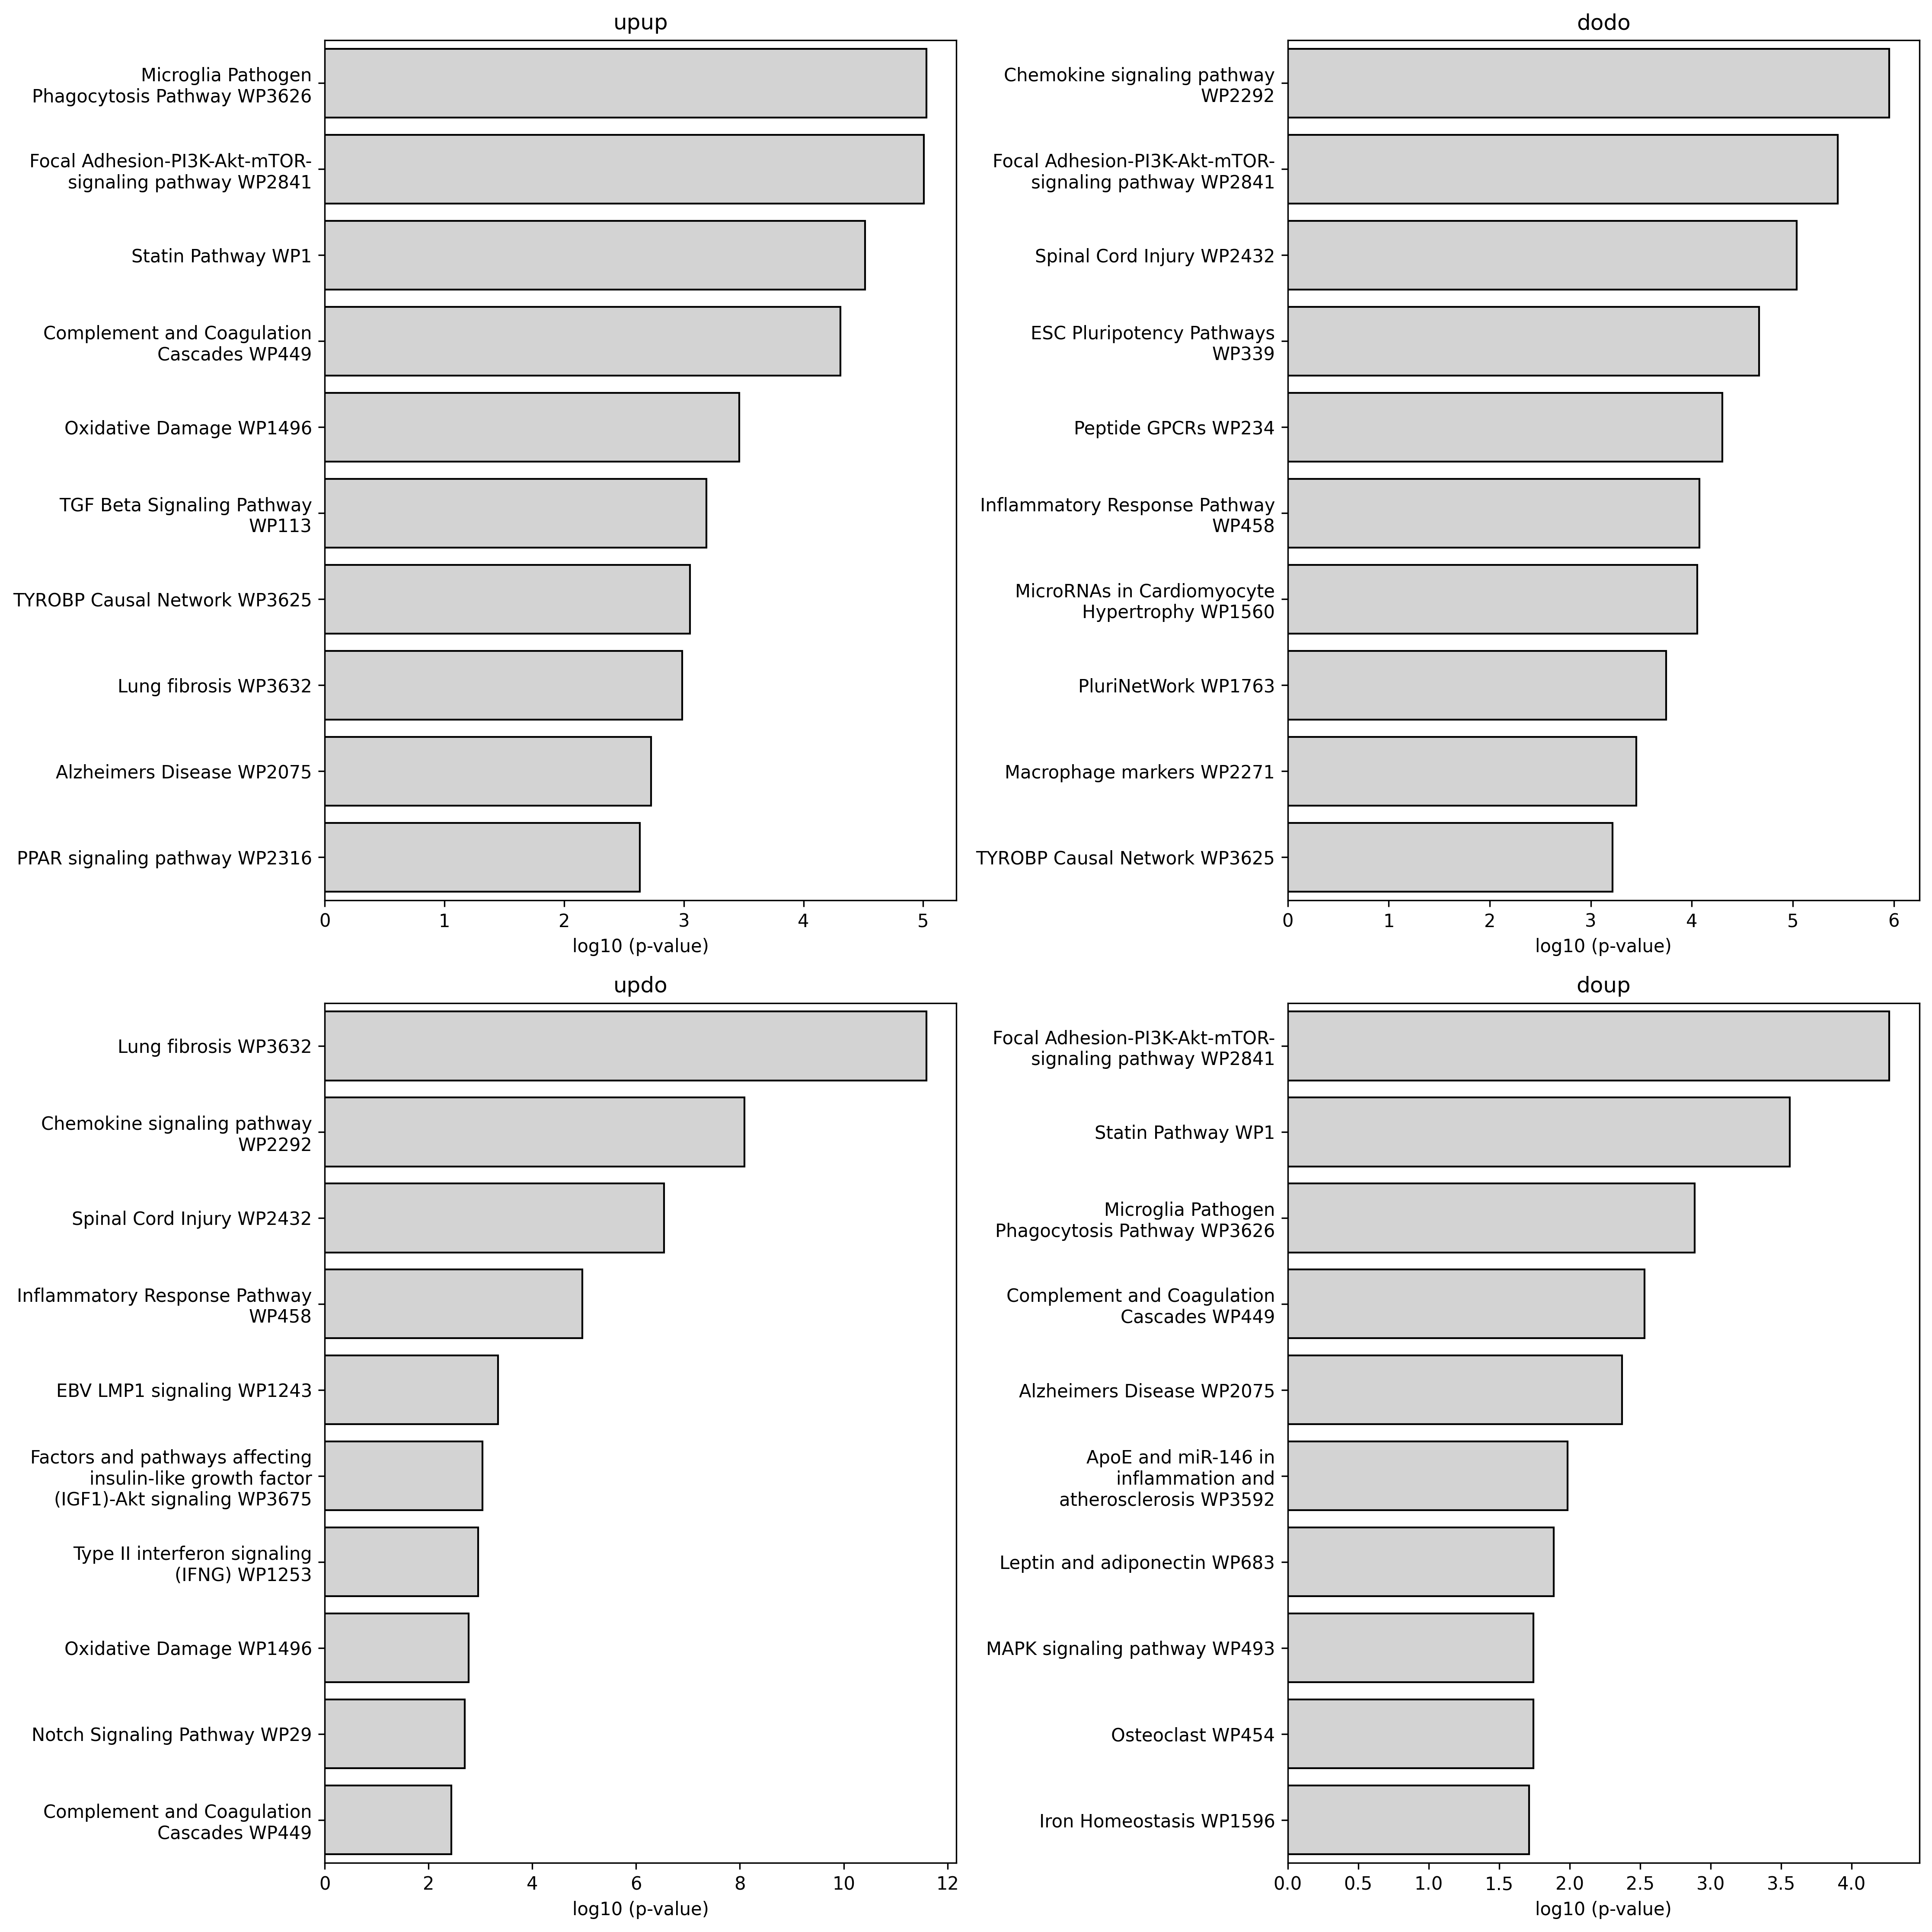

In [28]:
pdf = res2.copy()

# drop genes not in all three times
pdf['geneCount'] = pdf.groupby('gene')['key'].transform('count')
pdf = pdf[pdf['geneCount'] == 3]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

fig, axs = plt.subplots(2, 2)
axs = axs.ravel()


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 15, 15
plt.rcParams['figure.facecolor'] = "w"

fig, axs2 = plt.subplots(2, 2)
axs2 = axs2.ravel()

top = 20
nPathway = 10

sorts = {
    'upup' : ['ND', False],
    'dodo' : ['HFD14', True],
    'updo' : ['HFD8', False],
    'doup' : ['HFD8', True],
}


for i, dyn in enumerate(res2['dynamics'].unique()):
    ddf = res2[res2['dynamics'] == dyn]
    
    # geneSample = np.random.choice(ddf['gene'], sample, replace=False)
    # ddf = ddf[ddf['gene'].isin(geneSample)]
    
    ddf = ddf.sort_values(by='key', ascending=False)
    
    print(ddf.shape)
    
    ddf['geneName'] = ddf['gene'].apply(lambda x: str(x).lower().capitalize())
    ddf['logExp'] = np.log(ddf['meanExp'])
    # print(ddf['logExp'].describe())
    
    M = pd.pivot_table(ddf, 
                       index=['geneName'],
                       columns=['key'],
                       values='logExp')
    
    M = M[M.columns[::-1]]
    M = M.sort_values(by=sorts[dyn][0], ascending=sorts[dyn][1])
    M = M.sort_values(by=['ND', 'HFD8', 'HFD14'], ascending=[False, False, False])
    genes = M.index.to_list()
    sns.heatmap(M.head(top),
                linewidths=1,
                linecolor='k',
                cmap='coolwarm',
                # vmin=1,
                # vmax=10,
                # cbar=False,
                ax=axs[i])
    
    
    
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_title(dyn)
    
    db = 'WikiPathways_2019_Mouse'
    # db = 'KEGG_2019_Mouse'
    # db = 'ontology'

    ef = gget.enrichr(genes, database=db)
    ef['logp'] = ef['p_val'].apply(lambda x: -np.log10(x))
    ef['pathName'] = ['\n'.join(wrap(l,  width=30)) for l in ef['path_name']]

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.facecolor'] = "w"
    plt.rcParams['figure.figsize'] = 4, 4

    sns.barplot(data=ef.head(nPathway), 
                x='logp', 
                y='pathName', 
                color='lightgrey',
                edgecolor='k',  
                ax=axs2[i])
    
    axs2[i].set_ylabel("")
    axs2[i].set_xlabel("log10 (p-value)")
    axs2[i].set_title(dyn)

plt.tight_layout()
plt.tight_layout()

In [ ]:
# """ now for LR colocalization """
# allLR2 = [x for x in allLR if not "&" in x]


# lrDEG = []

# for key in keys:
#     sdf = spt[key]
    
#     expGene = {}
    
#     for idx, lrRow in lr.iterrows():
#         lig = lrRow['ligand']
#         rec = lrRow['receptor']
        
#         if lig in allLR2 and lig in sdf.columns and rec in allLR2 and rec in sdf.columns:
#             lrName = f"{lig}_{rec}"
#             gmean = sdf[[lig, rec]].apply(lambda x: scipy.stats.gmean(x), axis=1)
#             expGene[lrName] = gmean
            
#     expGene = pd.DataFrame.from_dict(expGene)
#     expGene['key'] = key
#     print(expGene.head())
#     break

In [ ]:
for ikey, jkey in comps:
    
    mask = (res['ikey'] == ikey) & (res['jkey'] == jkey)
    
    pdf = res[mask]
    
    pdf = pdf.sort_values(by='log2foldchange', ascending=False)
    
    print(pdf.head())
    
    break

In [ ]:
res[['ikey', 'jkey']].value_counts().reset_index()


In [ ]:
break

In [ ]:
"""

NEED TO CONTROL FOR BROADLY DEGs
"""

In [ ]:
nQ = 100

ndvw8 = res[(res['ikey'] == 'HFD8') & (res['jkey'] == 'HFD14')]
ndvw8 = ndvw8.sort_values(by='log2foldchange', ascending=False)


genes = ndvw8['gene'].head(nQ)

# db = 'WikiPathways_2019_Mouse'
db = 'KEGG_2019_Mouse'
# db = 'ontology'

ef = gget.enrichr(genes, database=db)
print(ef.head(10))